![]("three_API.png")

# Getting Started with FastEstimator

## Overview
In this tutorial we are going to cover:
* Three main APIs of FastEstimator: Pipeline, Network, Estimator
* Two computation units: Op, Trace 
* How computation units connects
* Example code of image classification

## Welcome to FastEstimator
Welcome to FastEstimator(FE). Before jumping into the tutorial, we want you to picture a workflow of training a DL classification task. What blocks it needs and how those connect to each others? 

Now lets look at the workflow of this task in FastEstimator. It should looks straight-forward and match with your imagination. This graph will be an example as well as a starting point of introducing you to the whole FastEstimator API design.  

## Three main APIs
<img src="../image/three_API.PNG" alt="drawing" width="700"/>
There are three mains blocks: `Pipeline`, `Network`, `Estimator` in the workflow graph. Each of them respectively represent  three main components of all deep learning training workflow: data pipeline, network, and optimization plan. Data pipeline extracts data from disk to RAM, performs transformations, and then loads the data onto the device. Network stores trainable and differentiable graphs. Optimization plan combines data pipeline and network in an iterative process. FE users will interact with these three APIs for building any deep learning task. 

* `Pipeline`: Pipeline summarize Extraction-Transformation-Load (ETL) process. It contains the data source and data preprocess operations. <br> <br>
* `Network`: Network manage trainable model and untrainable graph. <br> <br>
* `Estimator`: Estimator wrap up both `Pipeline` and `Netowrk` together, and defines what else to do in the training loop except for updating the model. In this example, it can be calculating metrics or saving model weights into disk. 

## Two computation units
In the above workflow graph, there are some color-filled block haven't been introduced yet. They are computation units with different class name. The units in Pipeline and Network are called `Operator`(Op), and in Estimator called `Trace`. 

* `Op`: The computation unit in `Pipeline` and `Network`. In one hand they serve as data preproces step inside Pipeline. In the other hand they serve as data postprocess step, model function, and model update unit inside Network <br><br>
* `Trace`: The computation unit in `Estimator`. It is usually used as metric calculation or callback function for monitoring training and model saving.


### How to express Operator and Trace connection
### How mode works 

## Code example for MNIST image classification 
<img src="../image/three_API.PNG" alt="drawing" width="700"/>

### Step 1 - Data and `Pipeline` preparation
In this step, we will load MNIST training and validation datasets and prepare FastEstimator's pipeline.
#### Load dataset
We use fastestimator API to load the MNIST dataset and get the test set by splitting 50% evaluation set.

In [1]:
import fastestimator as fe
from fastestimator.dataset.data import mnist

train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)

#### Set up preprocessing pipline
In this example, the data preprocessing steps include expanding image dimension and normalizing the pixel value to range [0, 1]. We set up those processing step using Ops and meanwhile define the data source (loaded dataset) and batch size

In [2]:
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), 
                            Minmax(inputs="x", outputs="x_out")])

### Step 2 - `Network` construction
FastEstimator supports both Pytorch and Tensorflow, so this section can use both backend to implement.
We are going to only demonstate the Tensorflow way in this example.
#### Model construction
Here the model definition is going to be imported from the FastEstimator pre-defined architecture that is implemented in Tensorflow, and we create model instance by compiling it with specific model optimizer.

In [3]:
from fastestimator.architecture.tensorflow import LeNet

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

#### `Network` definition
We are going to connect the model and Ops together into a Network. Ops are the basic component of Network. They can be logic for loss calculation, model update units, and even model itself is also considered as an Op.

In [4]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp


network = fe.Network(ops=[
        ModelOp(model=model, inputs="x_out", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce", mode="!infer")
    ])

### Step 3 - `Estimator` definition and training
In this step, we define the Estimator to connect the Network with Pipeline and set the traces which compute accuracy (Accuracy), save best model (BestModelSaver)

In [5]:
from fastestimator.schedule import cosine_decay
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
import tempfile

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="accuracy", save_best_mode="max")
]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=2,
                         traces=traces,
                         max_steps_per_epoch=None)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.3094347; 
FastEstimator-Train: step: 100; ce: 0.32585213; steps/sec: 235.62; 
FastEstimator-Train: step: 200; ce: 0.19874175; steps/sec: 234.65; 
FastEstimator-Train: step: 300; ce: 0.20871027; steps/sec: 243.61; 
FastEstimator-Train: step: 400; ce: 0.039908946; steps/sec: 243.58; 
FastEstimator-Train: step: 500; ce: 0.16578937; steps/sec: 242.1; 
FastEstimator-Train: step: 600; ce: 0.120900676; steps/sec: 235.31; 
FastEstimator-Train: step: 700; ce: 0.023096317; steps/sec

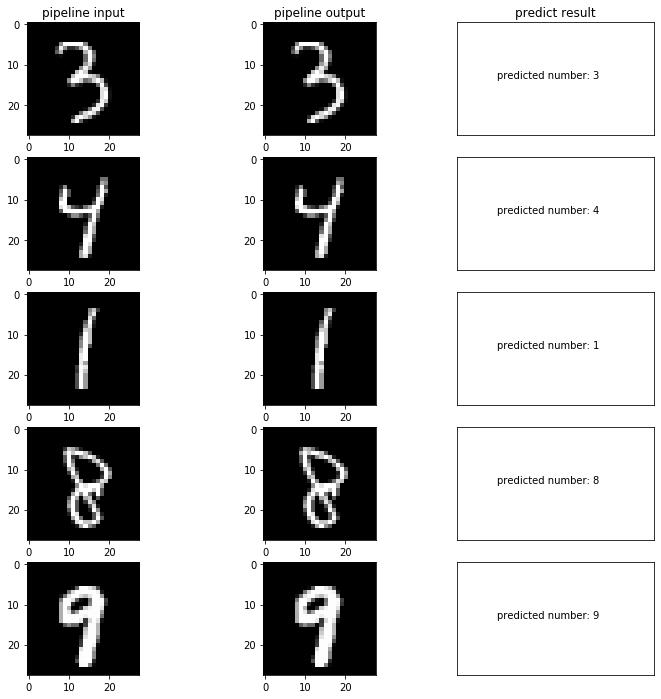

In [9]:
import matplotlib.pyplot as plt
import numpy as np

sample_num = 5

fig, axs = plt.subplots(sample_num, 3, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")
axs[0,2].set_title("predict result")

for i, j in enumerate(np.random.randint(low=0, high=31, size=sample_num)):
    data = {"x": test_data["x"][j]}
    axs[i,0].imshow(data["x"], cmap="gray")
    
    # run the pipeline
    data = pipeline.transform(data, mode="infer") 
    img = data["x_out"].squeeze(axis=(0,3))
    axs[i,1].imshow(img, cmap="gray")
    
    # run the network
    data = network.transform(data, mode="infer")
    predict = data["y_pred"].numpy().squeeze(axis=(0))
    axs[i,2].text(0.2, 0.5, "predicted number: {}".format(np.argmax(predict)))
    axs[i,2].get_xaxis().set_visible(False)
    axs[i,2].get_yaxis().set_visible(False)